In [1]:
from src.deep_ant import DeepAnt
from src import pipeline

import torch
import src
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
window_size = 64
train_loader, test_loader, test_df = pipeline.create_sin_dataset(
    window_size=window_size,
    device=device,
    shuffle=False,
    return_val_df=True,
    model_type="CNN"
)

Epoch 0, dataset train: Loss - 0.381005, MSE - 0.381005
Epoch 1, dataset train: Loss - 0.073014, MSE - 0.073014
Epoch 2, dataset train: Loss - 0.000609, MSE - 0.000609
Epoch 3, dataset train: Loss - 0.000205, MSE - 0.000205
Epoch 4, dataset train: Loss - 0.000086, MSE - 0.000086
Epoch 5, dataset train: Loss - 0.000041, MSE - 0.000041
Epoch 6, dataset train: Loss - 0.000023, MSE - 0.000023
Epoch 7, dataset train: Loss - 0.000015, MSE - 0.000015
Epoch 8, dataset train: Loss - 0.000011, MSE - 0.000011
Epoch 9, dataset train: Loss - 0.000009, MSE - 0.000009
Epoch 0, dataset train detector: Loss - 0.000008, MSE - 0.000008
Epoch 0, dataset evaluate detector: Loss - 0.029296, MSE - 0.029296


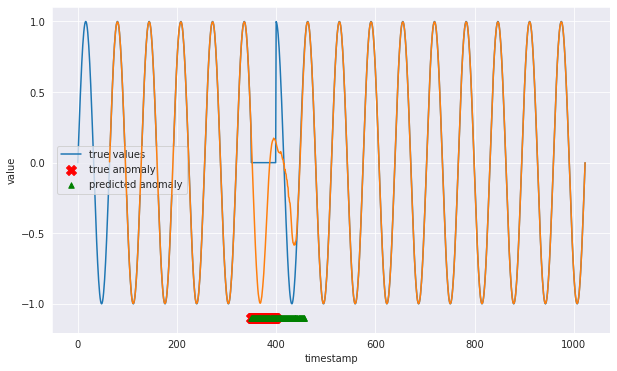

In [6]:
params = {
    "out_channels_1": 16,
    "kernel_size_1": 32,
    "stride_1": 1,
    "padding_1": 0,
    "out_channels_2": 32,
    "kernel_size_2": 5,
    "stride_2": 1,
    "padding_2": 0,
    "max_pool": 2,
    "linear_out_1": 128,
}
pipeline.train_evaluate(
    train_loader=train_loader,
    test_loader=test_loader,
    test_df=test_df,
    window_size=window_size,
    AnomalyDetector=DeepAnt,
    model_name="DeepAnt",
    n_epochs=10,
    verbose=1,
    plot_results=True,
    device=device,
    **params
)

In [ ]:
None=1

In [3]:
epochs = 10
params = {
    "out_channels_1": 16,
    "kernel_size_1": 32,
    "stride_1": 1,
    "padding_1": 0,
    "out_channels_2": 32,
    "kernel_size_2": 5,
    "stride_2": 1,
    "padding_2": 0,
    "max_pool": 2,
    "linear_out_1": 128,
}
model = DeepAnt(
        window_size=window,
        lr=1e-4,
        Optimizer=torch.optim.Adam,
        device=device,
        **params
).to(device)

In [4]:
model.train(train_loader=train_loader, validation_loader=None,
            epochs=5, model_name="DeepAnt", logdir="logs",
            verbose=1)

Epoch 0, dataset train: Loss - 0.364736, MSE - 0.364736
Epoch 1, dataset train: Loss - 0.076963, MSE - 0.076963
Epoch 2, dataset train: Loss - 0.002272, MSE - 0.002272
Epoch 3, dataset train: Loss - 0.000395, MSE - 0.000395
Epoch 4, dataset train: Loss - 0.000140, MSE - 0.000140


In [5]:
model.train_detector(train_loader)
# true_anomalies, pred_anomalies = model.evaluate_detector(test_loader)
# pipeline.plot_with_anomalies(df, np.where(true_anomalies > 0)[0], np.where(pred_anomalies > 0)[0], window=window)

Epoch 0, dataset train detector: Loss - 0.000084, MSE - 0.000084


Epoch 0, dataset evaluate detector: Loss - 0.029088, MSE - 0.029088


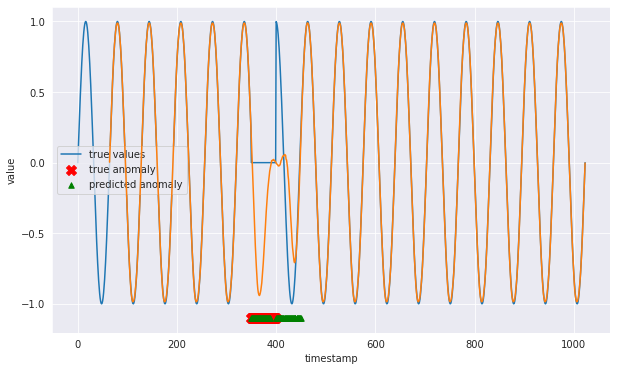

In [6]:
pipeline.show_results(
    model=model,
    validation_df=df,
    validation_loader=test_loader,
    window_size=window
)

In [7]:
#!rm -rf ./logs/DeepAnt